# Mood-RL Behavioral Preprocessing
## Extract and organize RL behavior

> Participants played three slot machine games, each involving three different slot machines (nine machines overall). Each machine had a distinct colour and a distinct pattern depicted on it, and some fixed probability of yielding reward when chosen. Unbeknownst to participants, within each game these probabilities were always 0.2, 0.4 and 0.6. On each trial, participants chose between two machines that appeared on the screen, and were either rewarded with 25 cents or not rewarded, according to the probability associated with the chosen machine. Participants had 3 s to make their choice. Each game consisted of 42 trials. 

In [1]:
import os
import numpy as np
from datetime import datetime
from pandas import DataFrame, concat
from scipy.io import loadmat

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
raw_dir = 'raw'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Locate files.
files = sorted(os.listdir(raw_dir)) 

df = []
for f in files:
    
    ## Load and extract data.
    mat = loadmat(os.path.join(raw_dir, f))
    data = mat['Data'].squeeze()
    
    ## Extract subject/datetime info.
    subject = subject, date, time = f.replace('.mat','').split('_')
    date = '-'.join(['%0.2d' %int(s) for s in date.split('-')])
    time = '-'.join(['%0.2d' %int(s) for s in time.split('-')])
    dt = datetime.strptime('%s %s' %(date,time), '%Y-%m-%d %H-%M-%S')
    
    ## Iterate over blocks.
    for blockno, block in enumerate(data):

        ## Separate data categories
        ## ------------------------
        ## - outcome: binary array indicating win (1) or loss (0).
        ## - onsets: list of arrays with task event onsets.
        ## - choice: integer array indicating machine chosen.
        ## - ratings: list of arrays with mood/probability ratings.
        ## - info: list of arrays of block information.
        outcome, onsets, choice, ratings, info = block

        ## Define machine identities
        ## -------------------------
        ## Machine stimulus and outcome probability are counterbalanced
        ## across participants. In the mat files, machines are labelled
        ## according to their stimulus, not their outcome probability.
        ## This section of code inverts this (i.e. identifies machine
        ## by outcome probability). This ultimately results in the 
        ## categorization scheme:
        ## - 20% probability = machines [1, 4, 7]
        ## - 40% probability = machines [2, 5, 8]
        ## - 60% probability = machines [3, 6, 9]
        _, presentation, identities = [arr.squeeze() for arr in info.squeeze().tolist()]
        if blockno < 3: identities += blockno * identities.size
        else: identities += np.repeat(np.arange(0,9,3),3).astype(identities.dtype)
        M1, M2 = identities[presentation-1]  

        ## Compute reaction times
        ## ----------------------
        ## Reaction times are simply computed from the onsets data.
        ## The second and third rows of the onsets matrix are
        ## stimulus and response onsets, respectively. Subtracting
        ## the second from the first returns the reaction time.
        onsets = np.array(onsets.squeeze().tolist()[:5]).squeeze()
        RT = onsets[2] - onsets[1]
            
        ## Compute outcome
        ## ---------------
        ## Outcome is already a binary vector (win = 1, lose = 0).
        ## This is simply multiplied by 0.25 for Blocks 1-3, and 
        ## by 0.50 for Blocks 4. 
        if blockno < 3: outcome = outcome * 0.25
        else: outcome = outcome * 0.50
        
        ## Assemble DataFrame
        ## ------------------
        ## Stores the following information: subject ID, block number, 
        ## trial number, machine 1/2, choice, reaction time, outcome.
        d = dict(Subject = np.repeat(subject, RT.size),
                 Datetime = np.repeat(dt, RT.size),
                 Block = np.repeat(blockno+1, RT.size),
                 Trial = np.arange(RT.size)+1,
                 M1 = M1, M2 = M2, Choice = choice.squeeze(),
                 RT = RT, Outcome = outcome.squeeze())
        df.append(DataFrame(d, columns=('Subject','Datetime','Block','Trial',
                                        'M1','M2','Choice','RT','Outcome')))

## Concatenate DataFrames.
df = concat(df)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Postprocessing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Handle missing data
## -------------------
## Missing choices and reaction times are set to NaNs. 
df.Choice = np.where(df.Choice==0, np.nan, np.where(df.Choice==1, df.M1, df.M2))
df.RT = np.where(df.Choice.isnull(), np.nan, df.RT)

## Save.
df.to_csv('data/moodRL_data_all.csv', index=False)
print('Done.')

Done.


## Extract and organize mood ratings.

> After the 7th, 21st and 35th trials, participants responded to the question '*how do you feel right now?*', by choosing one out of a series of figures whose face varied from unhappy to happy (the self-assessment manikin). After the 14th, 28th and 42nd trials, participants were asked to estimate how likely each of the three slot machines in the current game was to yield reward, between 0 and 100%.

In [2]:
import os
import numpy as np
from datetime import datetime
from pandas import DataFrame, concat
from scipy.io import loadmat

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
raw_dir = 'raw'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Locate files.
files = sorted(os.listdir(raw_dir)) 

df = []
for f in files:
    
    ## Load and extract data.
    mat = loadmat(os.path.join(raw_dir, f))
    data = mat['Data'].squeeze()
    
    ## Extract subject/datetime info.
    subject = subject, date, time = f.replace('.mat','').split('_')
    date = '-'.join(['%0.2d' %int(s) for s in date.split('-')])
    time = '-'.join(['%0.2d' %int(s) for s in time.split('-')])
    dt = datetime.strptime('%s %s' %(date,time), '%Y-%m-%d %H-%M-%S')
    
    ## Iterate over blocks.
    for blockno, block in enumerate(data[:-1]):

        ## Separate data categories
        ## ------------------------
        ## - outcome: binary array indicating win (1) or loss (0).
        ## - onsets: list of arrays with task event onsets.
        ## - choice: integer array indicating machine chosen.
        ## - ratings: list of arrays with mood/probability ratings.
        ## - info: list of arrays of block information.
        outcome, onsets, choice, ratings, info = block
        
        ## Organize ratings
        ## ----------------
        ## Mood and probability ratings are queried on the (7, 21, 35) and 
        ## (14, 28, 42) trial respectively. Probability judgments are 
        ## re-sorted by objective probability of reward in ascending order. 
        _, _, identities = [arr.squeeze() for arr in info.squeeze().tolist()]
        _, _, moods, probabilities = ratings.squeeze().tolist()
        probabilities = probabilities[:,identities-1]
        
        ## Merge ratings.
        trials = [7, 21, 35] + [14, 28, 42] * 3
        ratings = np.concatenate([moods.squeeze(), probabilities.flatten(order='F')])
        variables = np.repeat(np.arange(1+3*blockno,4+3*blockno), 3)
        variables = np.concatenate([np.repeat('Mood',3), variables])
        
        ## Assemble DataFrame
        ## ------------------
        ## Stores the following information: subject ID, datetime, 
        ## block number, rating type, trial number, rating.
        d = dict(Subject = np.repeat(subject, ratings.size),
                 Datetime = np.repeat(dt, ratings.size),
                 Block = np.repeat(blockno+1, ratings.size),
                 Trial = trials,
                 Variable = variables, 
                 Rating = ratings)
        df.append(DataFrame(d, columns=('Subject','Datetime','Block','Trial',
                                        'Variable','Rating')))

    ## Extract mood ratings collected at beginning of blocks 1 & 2.
    mood_ix = np.argmax(np.in1d(mat['Rt'].dtype.names, 'mood'))
    moods = mat['Rt'].squeeze().tolist()[mood_ix].squeeze()
    
    ## Assemble DataFrame.
    d = dict(Subject = np.repeat(subject, 2),
             Datetime = np.repeat(dt, 2),
             Block = np.arange(2) + 1,
             Trial = np.zeros(2, dtype=int),
             Variable = np.repeat('Mood',2), 
             Rating = moods)
    df.append(DataFrame(d, columns=('Subject','Datetime','Block','Trial','Variable','Rating')))
        
## Concatenate DataFrames.
df = concat(df)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Postprocessing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Re-sort by trial.
df = df.sort_values(['Subject','Datetime','Block','Trial'])

## Save.
df.to_csv('data/moodRL_ratings_all.csv', index=False)
print('Done.')

Done.


## Extract and organize metadata.
> All participants filled out the international personality item pool (IPIP) version of the HPS. In addition, to mitigate a possible recency effect on choices in the final test game, we separated in time the second and third games, as well as the third and test games, by having participants fill out additional questionnaires, whose results were not analysed. These included the BIS/BAS scales, and the IPIP version of the NEO Personality Inventory.

In [3]:
import os
import numpy as np
from datetime import datetime
from pandas import DataFrame, Series, read_csv
from scipy.io import loadmat

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
raw_dir = 'raw'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Locate files.
files = sorted(os.listdir(raw_dir)) 

metadata = []
for f in files:
    
    ## Load data.
    mat = loadmat(os.path.join(raw_dir, f))
    
    ## Extract subject/datetime info.
    subject = subject, date, time = f.replace('.mat','').split('_')
    date = '-'.join(['%0.2d' %int(s) for s in date.split('-')])
    time = '-'.join(['%0.2d' %int(s) for s in time.split('-')])
    dt = datetime.strptime('%s %s' %(date,time), '%Y-%m-%d %H-%M-%S')
    
    ## Initialize Series object
    ## ------------------------
    ## In this first step, a Pandas Series object is initialized with the 
    ## following information: subject ID, datetime, eyetracking recorded, 
    ## fMRI recorded, Wheel of Fortune outcome.
    scan = int(mat['scan'])
    eyetrack = int(mat['eyetrack'])
    WoF = float(mat['WOF'].squeeze().tolist()[0])
    series = Series([subject,dt,scan,eyetrack,WoF], 
                    index=('Subject','Datetime','Scan','Eyetrack','WoF'))
    
    ## Extract and store survey data
    ## -----------------------------
    ## In this step, the survey information is extracted from the Matlab
    ## object and stored in the Series. Information is subdivided by 
    ## survey scale. 
    for data, survey in zip(mat['Rt'].squeeze().tolist(), mat['Rt'].dtype.names):

        ## Extract subscale names/data. Skip mood questions (stored elsewhere).
        scales = data.dtype.names
        data = np.array(data.squeeze().tolist()).squeeze()
        if survey == 'mood': continue 
            
        ## Iteratively store.
        for datum, scale in zip(data, scales):
            series['%s_%s' %(survey,scale)] = datum
    
    ## Append series object.
    metadata.append(series)
    
## Concatenate Series objects.
metadata = DataFrame(metadata)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Postprocessing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Calculate earnings
## ------------------
## Total earnings are calculated based on the summed total outcomes
## of the reinforcement learning task (Blocks 1-3) and machine 
## discrimination task (Block 4), and the outcome on the Wheel of
## Fortune task. The former are calculated from the RL data spreadsheet.
data = read_csv('data/moodRL_data_all.csv')
outcomes = data.groupby('Datetime').Outcome.sum()
metadata.insert(4, 'Outcomes', outcomes.as_matrix())
metadata.insert(6, 'Earnings', metadata.WoF + metadata.Outcomes)

## Save.
metadata.to_csv('data/moodRL_metadata_all.csv', index=False)
print('Done.')

Done.


## Participant exclusion
> Eighteen additional trials involved pairs of machines with different reward probabilities. Of these latter trials, performance on those trials that involved one of the machines that had the highest reward probability (which we expected participants to recognize if they performed the task well) was examined to verify that participants were attentive and that they understood the task correctly. Data from one participant in the behavioural study and seven participants in the fMRI study, who did not perform above chance in the test game ($P > 0.1$, one-tailed binomial test) were excluded from further analysis.

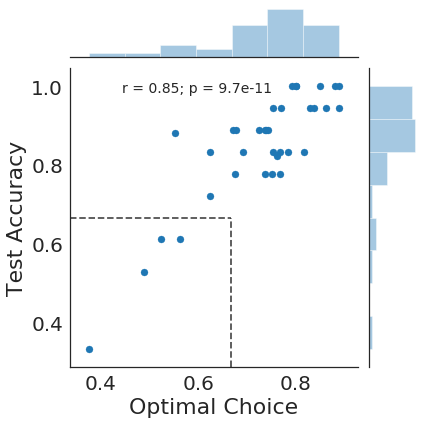

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from scipy.stats import binom
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Rejection parameters.
n_test_trials = 18
chance = 0.50
alpha = 0.1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv('data/moodRL_data_all.csv')
metadata = read_csv('data/moodRL_metadata_all.csv')
ratings = read_csv('data/moodRL_ratings_all.csv')

## Optimal choices.
ix = np.logical_and(data.Block<4, data.Choice.notnull())
optimal_choice = data[ix].copy()
optimal_choice['Optimal'] = np.equal(optimal_choice['Choice'], 
                                     optimal_choice[['M1','M2']].max(axis=1))
optimal_choice = optimal_choice.groupby('Datetime').Optimal.mean().reset_index()

## Discrimination check.
ix = np.logical_and(data.Block==4, data.Choice.notnull())
discrimination = data[ix].copy()
discrimination[['M1','M2','Choice']] = np.where(discrimination[['M1','M2','Choice']] % 3, 
                                                discrimination[['M1','M2','Choice']] % 3, 3)
discrimination = discrimination[~np.equal(discrimination['M1'],discrimination['M2'])]
discrimination['Optimal'] = np.equal(discrimination['Choice'], 
                                     discrimination[['M1','M2']].max(axis=1))
discrimination = discrimination.groupby('Datetime').Optimal.mean().reset_index()

## Merge.
gb = optimal_choice.merge(discrimination, on='Datetime')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Exclude participants.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define rejection level.
reject_level = binom.ppf(1-alpha, n_test_trials, chance) / n_test_trials

## Identify participants beneath threshold.
reject_id = gb.loc[gb.Optimal_y < reject_level, 'Datetime']

## Exclude participants and save.
data = data[~np.in1d(data.Datetime, reject_id)]
data.to_csv('data/moodRL_data.csv', index=False)

metadata = metadata[~np.in1d(metadata.Datetime, reject_id)]
metadata.to_csv('data/moodRL_metadata.csv', index=False)

ratings = ratings[~np.in1d(ratings.Datetime, reject_id)]
ratings.to_csv('data/moodRL_ratings.csv', index=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Plot.
g = sns.jointplot('Optimal_x', 'Optimal_y', data=gb,  annot_kws=dict(stat="r", fontsize=14),
                  marginal_kws=dict(hist_kws=dict(edgecolor='w', linewidth=1)))
g.set_axis_labels(xlabel='Optimal Choice', ylabel='Test Accuracy')

## Plot rejection levels.
xmin, xmax = g.fig.axes[0].get_xlim()
ymin, ymax = g.fig.axes[0].get_ylim()
g.fig.axes[0].hlines(reject_level, xmin, reject_level, linestyle='--', alpha=0.7)
g.fig.axes[0].vlines(reject_level, ymin, reject_level, linestyle='--', alpha=0.7)
g.fig.axes[0].set(xlim=(xmin,xmax), ylim=(ymin,ymax))

plt.tight_layout()